# Clustering and PCA

### Mushroom Dataset

Podeis obtener el conjunto de datos en el siguiente enlace:

[Mushroom Dataset](https://www.kaggle.com/uciml/mushroom-classification)

Como podréis comprobar, hay muchas variables, todas ellas categóricas, por lo que exploraciones con scatterplot no nos serán útiles como en otros casos.

La variable a predecir ``class`` es binaria.


In [1]:
# Carga de librerías, las que hemos considerado básicas, añadid lo que queráis :)

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from ucimlrepo import fetch_ucirepo
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

### Leer conjunto de datos y primer vistazo

In [2]:
# Leer el csv y sacar por pantalla las cinco primeras filas.
# https://archive.ics.uci.edu/dataset/73/mushroom

from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
mushroom = fetch_ucirepo(id=73) 
  
# data (as pandas dataframes) 
X = mushroom.data.features 
y = mushroom.data.targets 
df = pd.concat([X, y], axis=1)
  
# metadata 
print(mushroom.metadata) 
  
# variable information 
print(mushroom.variables) 
print(df.head(5))

{'uci_id': 73, 'name': 'Mushroom', 'repository_url': 'https://archive.ics.uci.edu/dataset/73/mushroom', 'data_url': 'https://archive.ics.uci.edu/static/public/73/data.csv', 'abstract': 'From Audobon Society Field Guide; mushrooms described in terms of physical characteristics; classification: poisonous or edible', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 8124, 'num_features': 22, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['poisonous'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1981, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5959T', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family (pp. 500-525).  Each species is identified as definitely edible, definitely po

### Exploración de datos

In [3]:
# Descripción del conjunto de datos, estándard.
df.describe()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat,poisonous
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,6,4,10,2,9,2,2,2,12,2,...,9,9,1,4,3,5,9,6,7,2
top,x,y,n,f,n,f,c,b,b,t,...,w,w,p,w,o,p,w,v,d,e
freq,3656,3244,2284,4748,3528,7914,6812,5612,1728,4608,...,4464,4384,8124,7924,7488,3968,2388,4040,3148,4208


In [4]:
# Información sobre el tipo de datos de cada feature.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   cap-shape                 8124 non-null   object
 1   cap-surface               8124 non-null   object
 2   cap-color                 8124 non-null   object
 3   bruises                   8124 non-null   object
 4   odor                      8124 non-null   object
 5   gill-attachment           8124 non-null   object
 6   gill-spacing              8124 non-null   object
 7   gill-size                 8124 non-null   object
 8   gill-color                8124 non-null   object
 9   stalk-shape               8124 non-null   object
 10  stalk-root                5644 non-null   object
 11  stalk-surface-above-ring  8124 non-null   object
 12  stalk-surface-below-ring  8124 non-null   object
 13  stalk-color-above-ring    8124 non-null   object
 14  stalk-color-below-ring  

#### Calcular el número de nulos de cada feature

In [5]:
# Igual que otras veces, una linea, contar los nulos por variable.
df.isnull().sum()

cap-shape                      0
cap-surface                    0
cap-color                      0
bruises                        0
odor                           0
gill-attachment                0
gill-spacing                   0
gill-size                      0
gill-color                     0
stalk-shape                    0
stalk-root                  2480
stalk-surface-above-ring       0
stalk-surface-below-ring       0
stalk-color-above-ring         0
stalk-color-below-ring         0
veil-type                      0
veil-color                     0
ring-number                    0
ring-type                      0
spore-print-color              0
population                     0
habitat                        0
poisonous                      0
dtype: int64

#### Buscar valores extraños. Para ello, ver los valores únicos en cada feature

In [6]:
# Obtener un nuevo dataframe de dos columnas donde en la primera estén las features (features) y en la otra los valores únicos
# asociados (n_values).
n_values = pd.DataFrame({'feature': df.columns, 'n_values': [df[col].nunique() for col in df.columns]})
n_values.head()

,feature,n_values
0,cap-shape,6
1,cap-surface,4
2,cap-color,10
3,bruises,2
4,odor,9


#### Tratar aquellos valores que entendamos que sean nulos


In [7]:
# Imputaciones. Podéis quitar esos puntos (fila entera), imputar con la moda o dejar ese valor como una posibilidad más.
df = df.dropna()  # Eliminar filas con valores nulos 

#### Mirad cuántos valores hay en cada feature, ¿Todas las features aportan información? Si alguna no aporta información, eliminadla

In [8]:
# Dejar por el camino si procede.
n_features = pd.DataFrame({'feature': df.columns, 'n_values': [df[col].value_counts() for col in df.columns]})
print(n_features)

                     feature  \
0                  cap-shape   
1                cap-surface   
2                  cap-color   
3                    bruises   
4                       odor   
5            gill-attachment   
6               gill-spacing   
7                  gill-size   
8                 gill-color   
9                stalk-shape   
10                stalk-root   
11  stalk-surface-above-ring   
12  stalk-surface-below-ring   
13    stalk-color-above-ring   
14    stalk-color-below-ring   
15                 veil-type   
16                veil-color   
17               ring-number   
18                 ring-type   
19         spore-print-color   
20                population   
21                   habitat   
22                 poisonous   

                                             n_values  
0   cap-shape
x    2840
f    2432
b     300
k     ...  
1   cap-surface
y    2220
f    2160
s    1260
g   ...  
2   cap-color
g    1696
n    1164
y    1056
w     ...  
3   bru

#### Separar entre variables predictoras y variables a predecir

In [9]:
# La variable que trata de predecir este conjunto de datos es 'poisonous'.
y = df['poisonous']
X = df.drop(columns=['poisonous'])

#### Codificar correctamente las variables categóricas a numéricas

In [10]:
# One Hot Encoder (una linea).
X_Encoded = pd.get_dummies(X, drop_first=True)

In [21]:
X_Encoded.shape  

(5644, 76)

#### Train test split

In [11]:
# Os lo dejamos a todos igual
X_train, X_test, y_train, y_test = train_test_split(X_Encoded, y, test_size=0.33, random_state=42)

## PCA - Principal Component Analysis

Es un conjunto de datos del que aún no hemos visto nada (no tenemos graficas) así que vamos a hacer algunas. Tenemos el problema de que son muchas variables, **PCA al rescate**: le pedimos que nos de dos dimensiones y las pintamos, sabemos que serán **aquellas que retengan más información**.

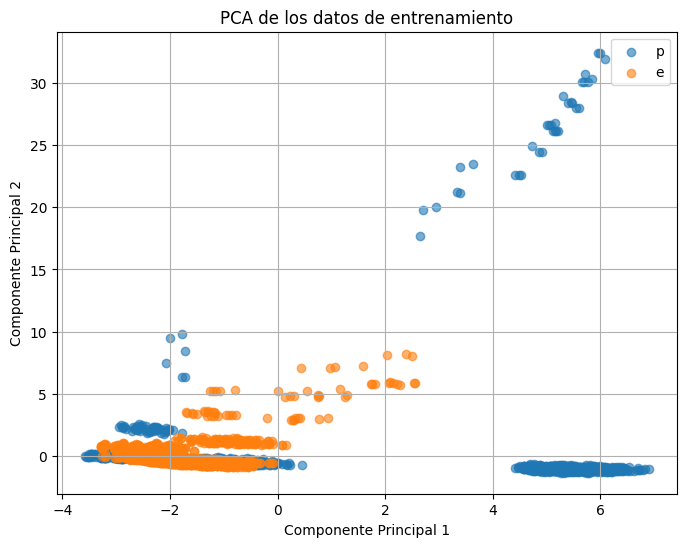

In [12]:
# Escalado previo (obligatorio para PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Aplicar PCA
pca = PCA(n_components=2)      # Reducimos a 2 componentes para graficar
X_pca = pca.fit_transform(X_scaled)

# Convertir a DataFrame para visualización
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['label'] = y_train.values

# Graficar
plt.figure(figsize=(8,6))
for label in pca_df['label'].unique():
    plt.scatter(
        pca_df[pca_df['label'] == label]['PC1'],
        pca_df[pca_df['label'] == label]['PC2'],
        label=label,
        alpha=0.6
    )

plt.title('PCA de los datos de entrenamiento')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend()
plt.grid(True)

Parece que está bastante separadito, parece que a ojo mucho se puede ver :)

Igualmente, vamos a entrenar un clasificador a ver qué tal lo hace antes de editar más

Precisión del modelo Random Forest: 1.00


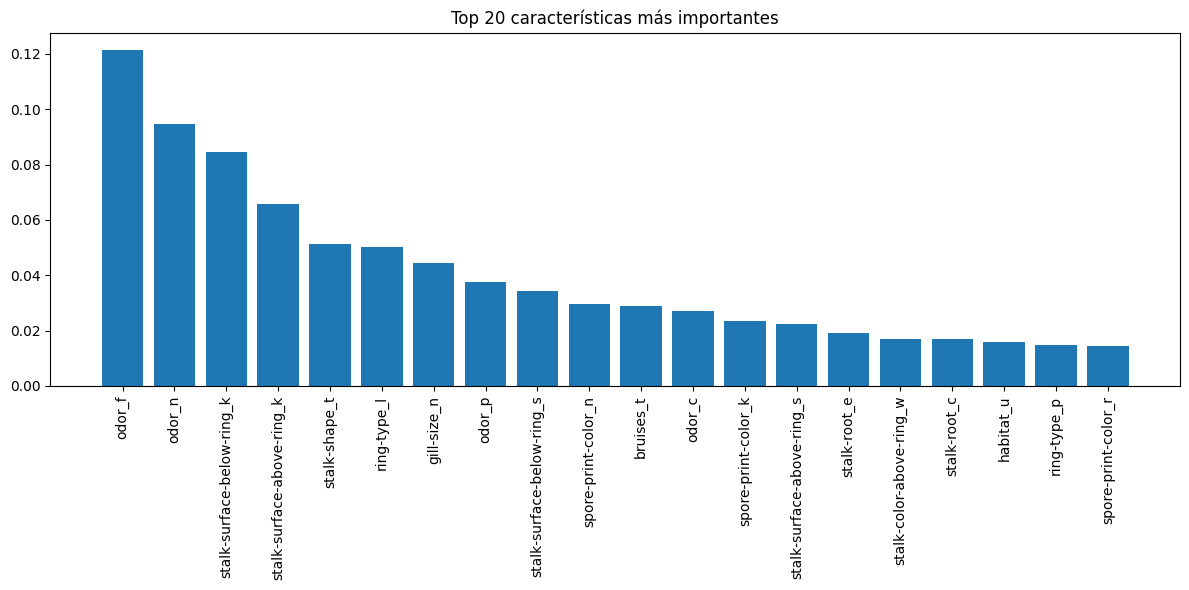

In [13]:
# import numpy as np
# import matplotlib.pyplot as plt


# ⚠️ Asegúrate de que X es el dataframe codificado con get_dummies
# por ejemplo:
# X = pd.get_dummies(df.drop(columns=['class']), drop_first=True)

# ⚠️ Asegúrate también de dividir los datos a partir de X codificado:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 1. Definir el clasificador y el número de estimadores
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# 2. Entrenar en train
clf.fit(X_train, y_train)

# 3. Calcular la precisión sobre test
accuracy = clf.score(X_test, y_test)
print(f'Precisión del modelo Random Forest: {accuracy:.2f}')

# 4. Graficar la importancia de las características
importances = clf.feature_importances_
feature_names = X_train.columns  # usar las columnas del dataframe codificado
indices = np.argsort(importances)[::-1]

# Limitar a las 20 características más importantes para mejor visualización
top_n = 20
plt.figure(figsize=(12, 6))
plt.title('Top 20 características más importantes')
plt.bar(range(top_n), importances[indices[:top_n]], align='center')
plt.xticks(range(top_n), feature_names[indices[:top_n]], rotation=90)
plt.tight_layout()
plt.show()


Es un conjunto sencillo y Random Forest es muy bueno en su trabajo, Igualmente, vamos a ver qué tamaño tenemos de dataset:


In [14]:
X_train.shape

(3781, 76)

¿Muchas features no? Vamos a reducir las usando PCA.

<Axes: >

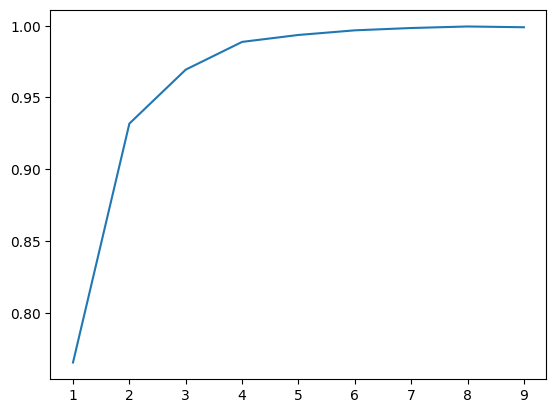

In [15]:
n_features = range(1,10)     #range(1, X_train.shape[1] + 1)  # desde 1 hasta número total de columnas
  # definir un rango de valores a probar
scores = []

for n in n_features:

    # Hacer PCA sobre X_train
    # 1. Definir PCA
    pca = PCA(n_components=n)  # Definir PCA con n componentes
    # 2. Aprender PCA sobre X_train
    X_train_pca = pca.fit_transform(X_train)
    # Entrenar Random Forest
    # 1. Definir el RF
    ramForest = RandomForestClassifier(n_estimators=100, random_state=42)
    # 2. Entrenar clasificador
    ramForest.fit(X_train_pca, y_train)
    # 3. Calcular la precisión sobre test
    X_test_pca = pca.transform(X_test)  # Transformar X_test con PCA
    score = ramForest.score(X_test_pca, y_test)
    #Guardar
    scores.append(score)
    


sns.lineplot(x=n_features, y=scores)


Vale, estamos viendo que a partir de unas 10 features ya tenemos el score que queríamos y además hemos reducido las variables a un 10% de las que teníamos, incluso menos que las variables originales.

## Clustering

Viendo que el conjunto de datos es sencillito, podemos intentar hacer algo de clustering a ver qué información podemos obtener.

El primer paso va a ser importar la función de Kmeans de sklearn, y a partir de ahi, vamos a buscar el valor óptimo de clusters. Como hemos visto anteriormente, este valor lo obtenemos, por ejemplo, del codo de la gráfica que representa el total de las distancias de los puntos a los centros de los clusters asociados. Os dejo la página de la documentación de sklearn para que lo busquéis:

[K-Means on sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

Con esto solo hay que ahora generar los modelos de kmeans, evaluar y pintar la gráfica para los valores de ``k`` que establezcais.




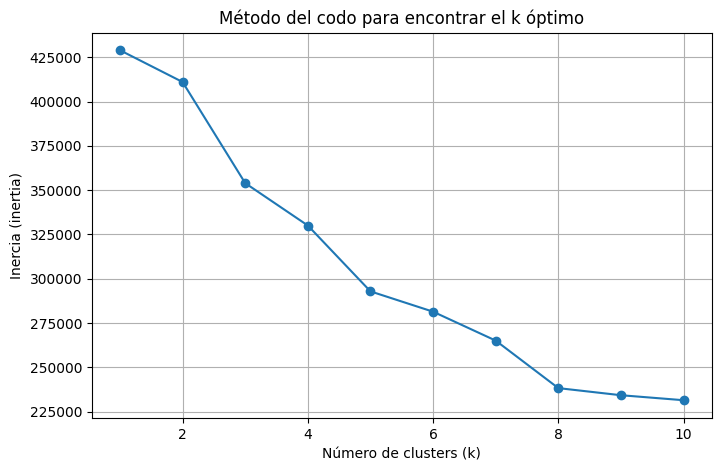

In [16]:
from sklearn.cluster import KMeans

# Escalar los datos (es muy importante para clustering)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_Encoded)

# Probar valores de k del 1 al 10
inertias = []
k_values = range(1, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Inercia (inertia)')
plt.title('Método del codo para encontrar el k óptimo')
plt.grid(True)
plt.show()

Con el valor que hayáis obtenido de la gráfica, podéis obtener una buena aproximación de Kmeans y con ello podemos pasar a explorar cómo de bien han separado la información los distintos clusters. Para ello, se va a hacer un ``catplot``, seaborn os lo hará solito. Con esto lo que se pretende ver es la distribución de la varaible a predecir en función del cluster que haya determinado Kmeans.

In [17]:
X_Encoded.head(5)

,cap-shape_c,cap-shape_f,cap-shape_k,cap-shape_s,cap-shape_x,cap-surface_g,cap-surface_s,cap-surface_y,cap-color_c,cap-color_e,...,population_c,population_n,population_s,population_v,population_y,habitat_g,habitat_l,habitat_m,habitat_p,habitat_u
0,False,False,False,False,True,False,True,False,False,False,...,False,False,True,False,False,False,False,False,False,True
1,False,False,False,False,True,False,True,False,False,False,...,False,True,False,False,False,True,False,False,False,False
2,False,False,False,False,False,False,True,False,False,False,...,False,True,False,False,False,False,False,True,False,False
3,False,False,False,False,True,False,False,True,False,False,...,False,False,True,False,False,False,False,False,False,True
4,False,False,False,False,True,False,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False


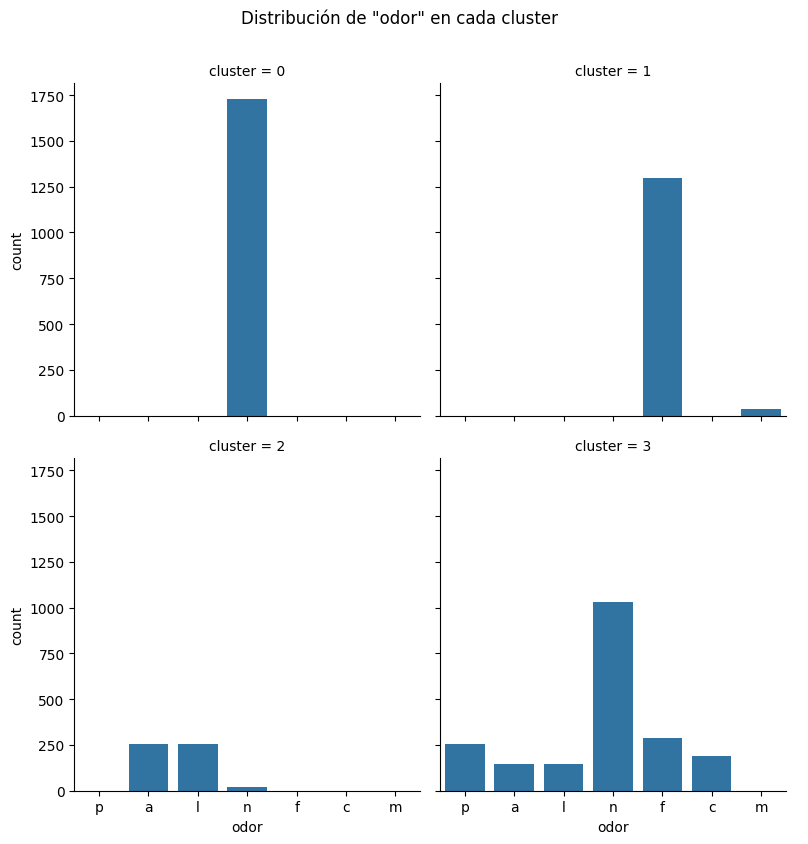

In [18]:
# Aprender Kmeans con el valor de K obtenido.
# 1. Escalar los datos (si no lo has hecho ya)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_Encoded)

# 2. Entrenar KMeans con K=4
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# 3. Crear una copia del DataFrame original para graficar

df_plot = df.copy()
df_plot.head(5)
df_plot['cluster'] = clusters

# 4. Preparar catplot: distribución de una variable categórica por cluster
# Por ejemplo, supongamos que quieres contar cuántas veces aparece cada valor de la variable 'odor'

ax = sns.catplot(
    col='cluster',      # una columna por cada cluster
    x='odor',           # en el eje X, la variable categórica
    data=df_plot,       
    kind='count',       
    col_wrap=2,         # para acomodar las gráficas en 2 columnas
    height=4
)

ax.fig.suptitle('Distribución de "odor" en cada cluster', y=1.05)
plt.show()

Vamos a ver qué tal queda esto pintado. Para ello, repetimos el scatterplot de antes pero usando como color el cluster asignado por kmeans.

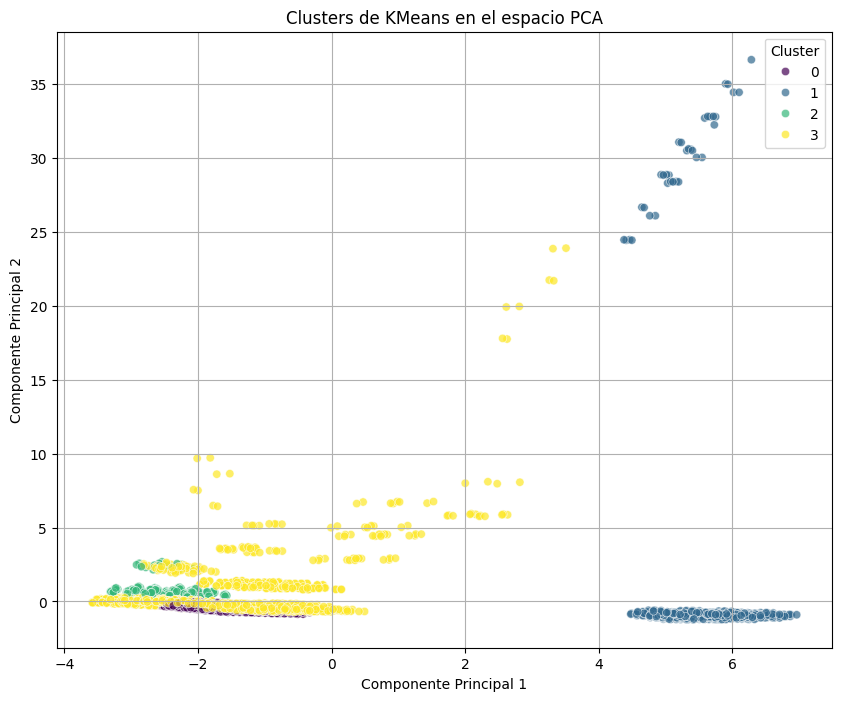

In [19]:
# Entrenar PCA para representar.
pca = PCA(n_components=2)  # Reducimos a 10 componentes para graficar
X_pca = pca.fit_transform(X_scaled)
# Convertir a DataFrame para visualización
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = clusters  # Añadir los clusters al DataFrame PCA
# Graficar los clusters en el espacio PCA
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='cluster', 
    data=pca_df, 
    palette='viridis',  # Usar una paleta de colores para distinguir los clusters
    alpha=0.7
)
plt.title('Clusters de KMeans en el espacio PCA')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)


# Usar un color por cada cluster.


¿Es bastante parecido no? No es tan bueno como el Random Forest, pero ha conseguido identificar bastante bien los distintos puntos del dataset sin utilizar las etiquetas. De hecho, el diagrama de factor que hemos visto antes muestra que solo un par de clusters son imprecisos. Si no hubieramos tenido etiquetas esta aproximacion nos hubiera ayudado mucho a clasificar los distintos tipos de hongos.